In [4]:
#install the requirements.
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
#----------------------------------
import matplotlib.pyplot as plt
import numpy as np


In [5]:
#load the datasets from PyTorch.

data_train = datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

In [6]:
#split the training data into training and validation datatest as well. 

train_size = int(0.8 * len(data_train))
val_size = len(data_train) - train_size
data_train, data_val = random_split(data_train, [train_size, val_size])

In [7]:
print(len(data_train))
print(len(data_val))

48000
12000


7062


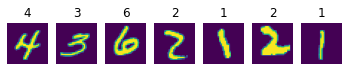

In [8]:
#visualize the dataset.
from random import randint
fig,ax = plt.subplots(1,7)
start = randint(0,len(data_train) - 7)
print(start)
for i in range(7):
    ax[i].imshow(data_train[start][0].view(28,28))
    ax[i].set_title(data_train[start][1])
    start = start + 1
    ax[i].axis('off')

In [9]:
#more info about the dataset.
print("training samples: ", len(data_train))
print("validation samples: ", len(data_val))
print("test samples: ", len(data_test))
print("structure of the tensor:", data_train[0][0].shape)

print("first ten values in the train data set are:", [data_train[i][1] for i in range(10)])

training samples:  48000
validation samples:  12000
test samples:  10000
structure of the tensor: torch.Size([1, 28, 28])
first ten values in the train data set are: [0, 9, 3, 0, 8, 9, 8, 1, 1, 2]


In [10]:
#define the LeNet model architecture.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def reset_parameters(self):
        for param in self.parameters():
            if param.requires_grad:
                param.data.uniform_(-0.1, 0.1)  # Reinitialize with desired initialization




In [11]:
#loading the dataset into the dataLoader.

train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size = 64, shuffle=True)
test_loader = DataLoader(data_test, batch_size=64)


In [12]:
from torchsummary import summary
#get the summary of the network.
net = LeNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net.to(device)

summary(net,(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [13]:
#define the loss function and the optimizer

loss = nn.CrossEntropyLoss()    #using the cross-entropy loss that is favored for multi-class classification
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)  #using the stochastic gradient descent optimizer.

In [14]:
print(device)

cuda


In [15]:
# define the train function and the validate function.

def train(net, dataloader, lr, optimizer, loss_fn):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        #print("the size of the labels", len(labels))
        
    #print("count is :", count)
    #print("the length of the dataloader is: ", len(dataloader))
    return total_loss.item()/count, acc.item()/count


In [16]:

def validate(model, dataloader, loss_fn):
    model.eval()  # Set the model to evaluation mode

    total_samples = 0
    correct_predictions = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / total_samples
    #print(f'Validation Accuracy: {accuracy * 100:.2f}% | Average Loss: {average_loss:.4f}')

    #print("the total samples is ",total_samples," and length of dataloader is ",len(dataloader))
    return average_loss, accuracy



In [17]:
# train the network using the model_train function

def model_train(net, train_loader, test_loader, optimizer, lr, epochs, loss):
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train(net, train_loader, lr, optimizer, loss)
        vl,va = validate(net, test_loader, loss)
        print(f"Epoch {ep + 1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
#         if ep % 10 == 0 : 
        res['train_loss'].append(tl) 
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

epochs = 100
hist = model_train(net,train_loader,val_loader, optimizer, 0.01, epochs, loss)

Epoch  0, Train acc=0.735, Val acc=0.953, Train loss=0.012, Val loss=0.002
Epoch  1, Train acc=0.902, Val acc=0.967, Train loss=0.005, Val loss=0.002
Epoch  2, Train acc=0.925, Val acc=0.973, Train loss=0.004, Val loss=0.001
Epoch  3, Train acc=0.935, Val acc=0.976, Train loss=0.003, Val loss=0.001
Epoch  4, Train acc=0.942, Val acc=0.976, Train loss=0.003, Val loss=0.001
Epoch  5, Train acc=0.946, Val acc=0.980, Train loss=0.003, Val loss=0.001
Epoch  6, Train acc=0.949, Val acc=0.981, Train loss=0.003, Val loss=0.001
Epoch  7, Train acc=0.953, Val acc=0.982, Train loss=0.002, Val loss=0.001
Epoch  8, Train acc=0.955, Val acc=0.982, Train loss=0.002, Val loss=0.001
Epoch  9, Train acc=0.956, Val acc=0.983, Train loss=0.002, Val loss=0.001
Epoch 10, Train acc=0.958, Val acc=0.984, Train loss=0.002, Val loss=0.001
Epoch 11, Train acc=0.959, Val acc=0.983, Train loss=0.002, Val loss=0.001
Epoch 12, Train acc=0.960, Val acc=0.984, Train loss=0.002, Val loss=0.001
Epoch 13, Train acc=0.960

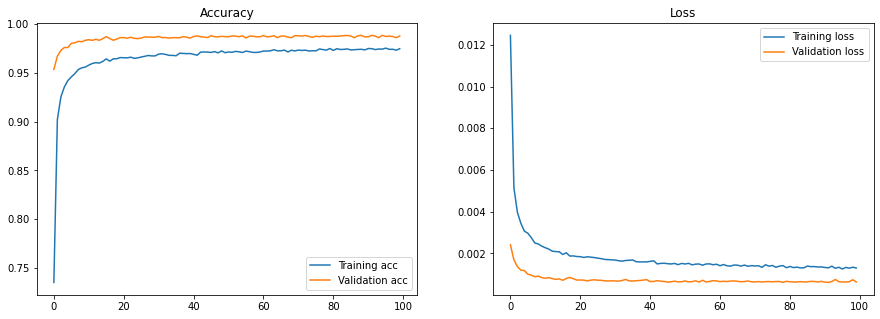

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.title('Loss')
plt.legend()

In [19]:
index = torch.randint(len(data_test), size = (1,)).item()
print(index)
features = data_test[index][0]
print("the label is:", data_test[index][1])
features = features.to(device)
out = net(features)
pred = torch.max(out,1)[1]
print(pred.item())


6158
the label is: 7
7


/usr/lib/python3/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [20]:
# test the model on the test_dataset

def test(net, dataset ):
    length = len(dataset)
    print(f"the length of the test dataset is {length}")
    correct = 0
    
    for i in range(length):
        feature = dataset[i][0]
        label = dataset[i][1]
        
        feature = feature.to(device)
        
        out = net(feature)
        pred = torch.max(out,1)[1]
        
#         if i % 100 == 0:
#             print(f"the label is {label} and it was predicted as {pred.item()}")
        
        correct += (pred == label).sum().item()

            
    
    print("the total correct guesses is ",correct)
    return correct/length   
        
    
    
    
print(test(net, data_test))

the length of the test dataset is 10000
the total correct guesses is  9899
0.9899


In [21]:
print("the test accuracy on the test dataset is", test(net, data_test) * 100)

the length of the test dataset is 10000
the total correct guesses is  9899
the test accuracy on the test dataset is 98.99


In [23]:
#save the model now.
import os

path = os.getcwd()
print(path)

model_path = path+"/lenet_MNIST.pth"

torch.save(net, model_path)


/home/ag8298/Desktop/Summer2023/lenet


In [25]:
print(model_path)

/home/ag8298/Desktop/Summer2023/lenet/lenet_MNIST.pth


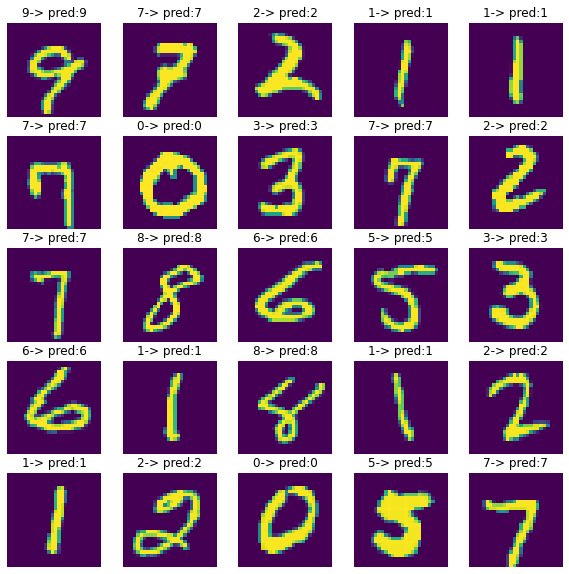

In [24]:
#visualize the prediction with the actual label and the predicted label 

figure = plt.figure(figsize = (10,10))
cols, rows = 5,5
for i in range(1, cols*rows + 1):
    index = torch.randint(len(data_test), size = (1,)).item()
    figure.add_subplot(rows, cols, i)
    img = data_test[index][0]
    label = data_test[index][1]
    #------------------------------
    features = img
    features = features.to(device)
    out = net(features)
    pred = torch.max(out,1)[1]
    #-----------------------------
    plt.title(f"{label}-> pred:{pred.item()}")
    plt.axis("off")
    plt.imshow(img.view(28,28))

    #plt.imshow(img.numpy().squeeze(),cmap="Greys")           # .squeeze() flattens the given tensor or matrix into 1-d array.
plt.show()